In [0]:
import torch
import torch.nn
import torch.optim
import torchvision.datasets
import torchvision.transforms
import torch.utils.data

In [0]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Autoencoder

## Module definition

Our autoencoder will be defined by the `ConvolutionalAutoencoder` class which uses a `ConvolutionalEncoder` object to encode followed a `ConvolutionalDecoder` object to decode. The `ConvolutionalEncoder` and `ConvolutionalDecoder` classes make use of `n_blocks` `ConvolutionalBlock`s or `DeconvolutionalBlock`s which are composed of `layer_per_block` convolution layers with the same number of filters.

The dimensionality is reduced by applying 2-factor spatial downsampling at each block. The number of filters is doubled for each subsequent block. The decoder makes the exact oposite process.

The final layer uses a tanh activation.

In [0]:
class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self, n_blocks, downsampling_method, upsampling_method,
                 layers_per_block=2):
        super().__init__()
        self.n_blocks = n_blocks
        self.downsampling_method = downsampling_method
        self.upsampling_method = upsampling_method

        self.encoder = ConvolutionalEncoder(n_blocks, downsampling_method,
                                            layers_per_block=layers_per_block)
        self.decoder = ConvolutionalDecoder(n_blocks, upsampling_method,
                                            self.encoder.output_channels,
                                            layers_per_block)

    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction


class ConvolutionalEncoder(torch.nn.Module):

    DOWNSAMPLING_METHODS = ["max-pooling", "avg-pooling", "stride-2"]

    def __init__(self, n_blocks, downsampling_method, init_filters=16,
                 layers_per_block=2, kernel_size=5, input_channels=1):
        super().__init__()
        self.n_blocks = n_blocks
        assert downsampling_method in self.DOWNSAMPLING_METHODS
        self.downsampling_method = downsampling_method
        self.layers_per_block = layers_per_block
        self.init_filters = init_filters
        self.kernel_size = kernel_size
        self.input_channels = input_channels

        layers = []

        # First layer so we have <init_filters> channels.
        n_filters = init_filters
        layers.append(
            ConvolutionalBlock(input_channels, n_filters, kernel_size, 1))

        # Encoding blocks.
        input_channels = n_filters
        for _ in range(n_blocks):
            if downsampling_method == "max-pooling":
                # Convolutional block + max pooling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, n_filters, kernel_size, layers_per_block),
                    torch.nn.MaxPool2d(2)
                )
            elif downsampling_method == "avg-pooling":
                # Convolutional block + average pooling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, n_filters, kernel_size, layers_per_block),
                    torch.nn.AvgPool2d(2)
                )
            else:
                # Stride-2 convolution.
                conv_block = ConvolutionalBlock(input_channels, n_filters,
                                                kernel_size,
                                                layers_per_block,
                                                last_stride=2)
            layers.append(conv_block)
            # Double the number of filters.
            input_channels = n_filters
            n_filters = 2 * n_filters

        self.encoder = torch.nn.Sequential(*layers)
        self.output_channels = input_channels

    def forward(self, x):
        return self.encoder(x)


class ConvolutionalDecoder(torch.nn.Module):

    UPSAMPLING_METHODS = ["transposed", "bilinear", "bicubic", "nearest"]

    def __init__(self, n_blocks, upsampling_method, input_channels,
                 layers_per_block=2, kernel_size=5, output_channels=1):
        super().__init__()
        self.n_blocks = n_blocks
        assert upsampling_method in self.UPSAMPLING_METHODS
        self.upsampling_method = upsampling_method
        self.layers_per_block = layers_per_block
        self.input_channels = input_channels
        self.kernel_size = kernel_size
        self.output_channels = output_channels

        layers = []

        # Decoding blocks.
        n_filters = input_channels
        for _ in range(n_blocks):
            if upsampling_method == "transposed":
                # Deconvolutional block
                conv_block = DeconvolutionalBlock(input_channels, n_filters,
                                                  kernel_size, layers_per_block,
                                                  stride=2)
            else:
                # Upsampling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, n_filters, kernel_size,
                                       layers_per_block),
                    torch.nn.Upsample(scale_factor=2, mode=upsampling_method)
                )
            layers.append(conv_block)
            # Half the number of filters.
            input_channels = n_filters
            n_filters = n_filters // 2

        # Last layer so we have <output_channels> channel.
        layers.append(torch.nn.Conv2d(input_channels, output_channels, kernel_size,
                                      padding=kernel_size // 2))
        layers.append(torch.nn.Tanh())

        self.decoder = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)


class ConvolutionalBlock(torch.nn.Module):
    """

    Applies n_layers convolutional layers with the same number of
    filters (n_filters) and filter sizes (kerne_size) with ReLU activations
    keeping the same spacial size.
    """

    def __init__(self, input_channels, n_filters, kernel_size, n_layers,
                 last_stride=1):
        super().__init__()
        layers = []
        padding = kernel_size // 2  # To keep the same size.

        for i in range(n_layers):
            if i == 0:  # First layer with correct input channels.
                layers.append(torch.nn.Conv2d(input_channels, n_filters,
                                              kernel_size, padding=padding))
            elif 0 < i < n_layers:  # Intermediate layers.
                layers.append(torch.nn.Conv2d(n_filters, n_filters,
                                              kernel_size, padding=padding))
            else:  # Last layer with stride.
                layers.append(torch.nn.Conv2d(n_filters, n_filters,
                                              kernel_size, last_stride, padding))
            layers.append(torch.nn.ReLU())

        # To sequentially apply the layers.
        self.block = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class DeconvolutionalBlock(torch.nn.Module):
    """

    Applies a transposed convolution followed by n_layers-1 convolutional
    layers with the same number of filters and filter sizes with ReLU
    activations keeping the same spacial size.
    """

    def __init__(self, input_channels, n_filters, kernel_size, n_layers, stride):
        super().__init__()
        layers = []
        padding = kernel_size // 2

        # Transposed convolution layer.
        layers.append(torch.nn.ConvTranspose2d(input_channels, n_filters,
                                               kernel_size, stride, padding))
        layers.append(torch.nn.ReLU())

        for _ in range(n_layers - 1):
            layers.append(torch.nn.Conv2d(n_filters, n_filters, kernel_size,
                                          padding=padding))
            layers.append(torch.nn.ReLU())

        # To sequentially apply the layers.
        self.block = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

To do a quick test, we will pass a random image and check if the output is of the same size as the input.

In [0]:
image = torch.randn((1, 1, 128, 128))
autoencoder = ConvolutionalAutoencoder(2, 'max-pooling', 'nearest').to(device)
output = autoencoder(image.to(device))
assert output.shape == (1, 1, 128, 128)

## Dataset

We split the training set and normalize the input images.

In [0]:
transform = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,))  # Mean and std from internet...
])

In [6]:
mnist = torchvision.datasets.MNIST('mnist_dataset', train=True, transform=transform, download=True)

0it [00:00, ?it/s]

9920512it [00:01, 8589457.60it/s]                            


Extracting mnist_dataset/MNIST/raw/train-images-idx3-ubyte.gz to mnist_dataset/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 130374.85it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_dataset/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_dataset/MNIST/raw


1654784it [00:00, 2132143.04it/s]                            
0it [00:00, ?it/s]

Extracting mnist_dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_dataset/MNIST/raw


8192it [00:00, 49428.94it/s]            


Extracting mnist_dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_dataset/MNIST/raw
Processing...
Done!


In [0]:
dataset_len = len(mnist)

In [8]:
dataset_len * 0.95

57000.0

In [0]:
mnist_train, mnist_val = torch.utils.data.random_split(mnist, [57000, dataset_len - 57000])

In [0]:
train_dataloader = torch.utils.data.DataLoader(mnist_train,
                                               batch_size=32,
                                               shuffle=True,
                                               num_workers=4)

In [0]:
mse = torch.nn.MSELoss()
adam = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [0]:
def train(model, dataloader, criterion, optimizer, epoch):
    for i, batch in enumerate(dataloader):
        images = batch[0].to(device)
        optimizer.zero_grad()
        reconstructed = model(images)
        loss = criterion(reconstructed, images)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print('[%d, %d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))

In [15]:
for epoch in range(5):
    train(autoencoder, train_dataloader, mse, adam, epoch)

[1, 1] loss: 0.983
[1, 101] loss: 0.427
[1, 201] loss: 0.407
[1, 301] loss: 0.395
[1, 401] loss: 0.335
[1, 501] loss: 0.355
[1, 601] loss: 0.328
[1, 701] loss: 0.346
[1, 801] loss: 0.340
[1, 901] loss: 0.354
[1, 1001] loss: 0.312
[1, 1101] loss: 0.274
[1, 1201] loss: 0.334
[1, 1301] loss: 0.343
[1, 1401] loss: 0.295
[1, 1501] loss: 0.372
[1, 1601] loss: 0.355
[1, 1701] loss: 0.320
[2, 1] loss: 0.333
[2, 101] loss: 0.340
[2, 201] loss: 0.318
[2, 301] loss: 0.312
[2, 401] loss: 0.320
[2, 501] loss: 0.353
[2, 601] loss: 0.317
[2, 701] loss: 0.347
[2, 801] loss: 0.318
[2, 901] loss: 0.325
[2, 1001] loss: 0.327
[2, 1101] loss: 0.364
[2, 1201] loss: 0.336
[2, 1301] loss: 0.341
[2, 1401] loss: 0.330
[2, 1501] loss: 0.342
[2, 1601] loss: 0.327
[2, 1701] loss: 0.331
[3, 1] loss: 0.349
[3, 101] loss: 0.316
[3, 201] loss: 0.283
[3, 301] loss: 0.345
[3, 401] loss: 0.341
[3, 501] loss: 0.324
[3, 601] loss: 0.316
[3, 701] loss: 0.329
[3, 801] loss: 0.324
[3, 901] loss: 0.347
[3, 1001] loss: 0.334
[3

In [0]:
mnist_test = torchvision.datasets.MNIST('mnist_dataset', train=False, transform=transform)

In [0]:
reconstructed = autoencoder(mnist_test[0][0].to(device).unsqueeze(0))

In [0]:
import matplotlib.pyplot as plt

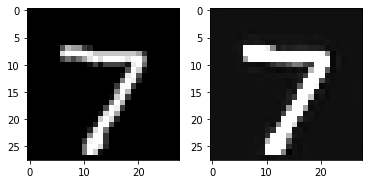

In [20]:
plt.subplot(121)
plt.imshow(mnist_test[0][0][0], cmap='gray')
plt.subplot(122)
plt.imshow(reconstructed[0][0].detach().cpu().numpy(), cmap='gray')